# Estimating the dispersion of image matching displacements
Functions and algorithms within the **dhdt** framework are for a large part dependent upon pattern matching. When such algorithms are formulated as a convolution, the cross-correlation function can have the form of a peak. The width of the peak can then be used as a proxy for precision.

Such a describtor of precision is of interest when information is extracted from such a velocity field. Since errors will propagate in any derived product. In the following, an example is given from a dataset of two images of Sentinel-2 over a large outlet glacier in Greenland. 

This work is a demonstration of the basic functionality, and a more detailed describtion can be found in [Altena et al. 2021](https://doi.org/10.5194/tc-2021-202).

### import of funcitons from libraries
First we need to import some generic libraries for file manipulation, downloading, array operations and plotting

In [1]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

Than more specific functions can be imported from the **dhdt** library

In [2]:
from dhdt.generic.mapping_io import read_geo_image, read_geo_info 
from dhdt.generic.mapping_tools import pix2map, get_bbox, pix_centers, map2ll, ref_update
from dhdt.processing.matching_tools import get_coordinates_of_template_centers, get_data_and_mask
from dhdt.processing.coupling_tools import match_pair
from dhdt.postprocessing.adjustment_geometric_temporal import rotate_variance
from dhdt.presentation.displacement_tools import plot_displacement_vectors

### data preparation
The satellite data is situated in the cloud (pun intended), but these can be downloaded to a local drive. Hence the following code sniplet looks if such data is already available, if not it is downloaded.

In [3]:
dat_dir = '/Users/Alten005/Gauss' # please change this line to the path of your prefered location
dat_url = 'https://surfdrive.surf.nl/files/index.php/s/7filDMbYkxiavk3'

I1_name = 'T22WEB_20200730T151921_B04_clip.tif'
I2_name = 'T22WEB_20200720T151911_B04_clip.tif'

# do downloading if files are not present
if not os.path.exists(os.path.join(dat_dir, I1_name)):
    file_grab = urllib.URLopener()
    print('busy downloading files') # dowload Sentinel-2 L1C imagery data
    file_grab.retrieve(os.path.join(dat_url, I1_name),
                       os.path.join(dat_dir, I1_))
    file_grab.retrieve(os.path.join(dat_url, I2_name),
                       os.path.join(dat_dir, I2_name))
    print('files dowloaded')
else:
    print('files are already present')

files are already present


### main processing
The imagery will be matched, here certain parameters should be given specifying the template size and its search space.

In [4]:
temp_radius,sear_radius = 10, 40

Now it is possible to read the imagery

In [5]:
spatialRef, geoTransform, targetprj,_,_,_ = read_geo_info(os.path.join(dat_dir, I1_name))
I1 = read_geo_image(os.path.join(dat_dir, I1_name))[0]
I2 = read_geo_image(os.path.join(dat_dir, I2_name))[0]
I_extent = get_bbox(geoTransform)
#I_x,I_y = pix_centers(geoTransform)
#I_ll = map2ll(np.stack((I_x.ravel(), I_y.ravel()), axis=1), spatialRef)
#I_lat, I_lon = I_ll[:,0].reshape(I1.shape), I_ll[:,1].reshape(I1.shape)

The image matching is done hereafter, where a small image template is compared against a large image domain. It estimates the relative displacement and also the width and orientation of the correlation correlation peak that corresponds to the displacement.

This calculation is done in a naive fasion, where the template is sampled on a predefined grid. Hence, this results is a lower resolution array.

In [6]:
sample_I, sample_J = get_coordinates_of_template_centers(I1, temp_radius)
sample_X, sample_Y = pix2map(geoTransform, sample_I, sample_J)
I1,M1 = get_data_and_mask(I1)
I2,M2 = get_data_and_mask(I2)

match_X, match_Y, match_score = match_pair(I1, I2, M1, M2,
                                           geoTransform, geoTransform,
                                           sample_X, sample_Y,
                                           temp_radius=temp_radius, search_radius=sear_radius,
                                           correlator='norm_corr', subpix='moment',
                                           metric='peak_ratio', processing='simple',
                                           precision_estimate='gaussian'
                                          ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████| 232580/232580 [07:18<00:00, 530.06it/s]


The algorithm estimates the new location of the template, this is not needed here, so the inititial coordinate grid is removed. Furthermore, an update of the spatial reference is needed, since the grid size is increased and shifted.

In [7]:
dX,dY = match_X-sample_X, match_Y-sample_Y
newTransform = ref_update(geoTransform, dX.shape[0], dX.shape[1])
new_extent = get_bbox(newTransform)

Now it is possible to create a plot showing the velocity structure of this fast flwoing outlet glacier. For this case, we do a more experimental visualization, where fringes or coloured contouring represent a step in five meters per day

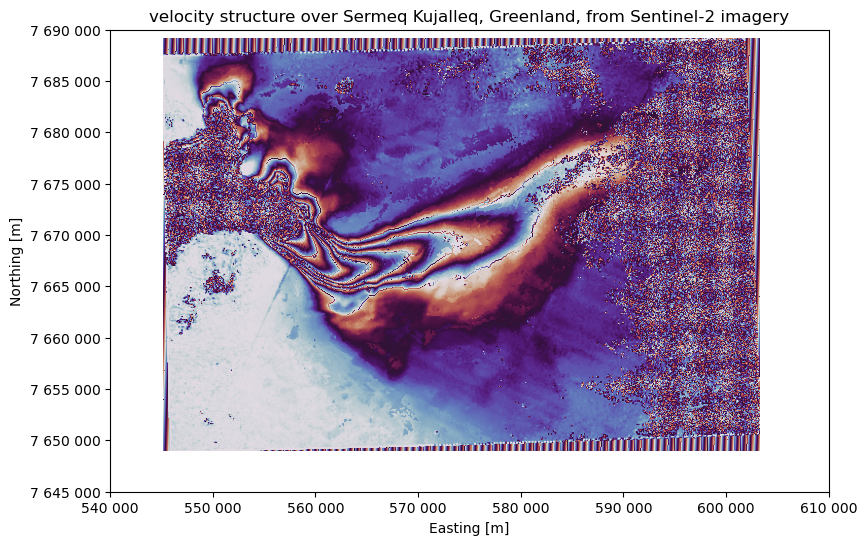

In [8]:
plt.rcParams['figure.figsize'] = [12.,6.]
fig, ax = plt.subplots()
ax.imshow(np.hypot(dX,dY)%50, extent=I_extent, cmap=plt.cm.twilight)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f"{int(item):,}".replace(',', ' ') for item in ax.get_xticks()])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{int(item):,}".replace(',', ' ') for item in ax.get_yticks()])
plt.xlabel('Easting [m]'), plt.ylabel('Northing [m]')
plt.title('velocity structure over Sermeq Kujalleq, Greenland, from Sentinel-2 imagery');

It is great that such data can be created, and many efforts are focussed towards a *complete* data-set. Noise is present in the figure above, and such points can be modified by imposing spatial-temporal relationships, in the form of filter. Though, this is not the route taken here, as we focus on transferability. We accept the fact that matching has failed at certain regions, but we do try to describe its precision. So, later algorithms in the product development chain are able to propagate errors, without the need of a larger understanding of the assumptions made by the in-filling procedures. 

In order to get a feeling about such point-wise accuracy description, a first step is to estimate the self similarity of an image. This can be done via different means, but an easy implementation is the feeding of two identical images into the matching procedure. If a small template has unique features within, it will have a large score in relation to other alternative candidates in the surround. While, if the information content within an image template is low, this will propagate as well. Hence, *self-similarity gives a proxy for uniqueness*. 

In [ ]:
self_score = match_pair(I1, I1, M1, M1,
                        geoTransform, geoTransform,
                        sample_X, sample_Y,
                        temp_radius=temp_radius, search_radius=sear_radius,
                        correlator='norm_corr', subpix='moment',
                        metric='peak_ratio', processing='simple',
                        precision_estimate=False)[2]

Since the image pair matching and the self similarity matching are produced through the same procedure it is possible to compare the two proxies and get an idea what properties such a measure captures.

In [ ]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
ax1.imshow(match_score[:,:,0], vmin=1.0, vmax=1.1, cmap=plt.cm.magma, extent=I_extent)
ax2.imshow(self_score, vmin=1.0, vmax=2.5, cmap=plt.cm.magma, extent=I_extent)
ax3.imshow(self_score-match_score[:,:,0], vmin=0.0, vmax=1.0, cmap=plt.cm.Reds, extent=I_extent)
ax1.set_title('matching score'), ax2.set_title('self similarity'), ax3.set_title('difference')
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f"{int(item):,}".replace(',', ' ') for item in ax1.get_yticks()]);

What can be seen above is a large difference in the fjord, this is highly contrasting ice melange, which has significantly changed in the ten days separating the two images. Other large differences occur in the middle of the scene where melting features might be changing. Another prenounching feature is present at the border of the turn, close to the calving front. This is due to significant shear. 

In the context of measurement accuracy, one can use the matching score as a proxy for reliability. While the measurement precision can be extracted from the width of the cross-correlation function. This dispersion estimation in the flow direction can be plotted, this variance can be specified either in along or across flow

In [ ]:
psi = np.arctan2(-dX,-dY)

qii_r,qjj_r = rotate_variance(psi, match_score[...,1], match_score[...,2], match_score[...,3])

In [ ]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
ax1.imshow(np.sqrt(qjj_r, where=qjj_r>0), vmin=0.0, vmax=10.0, cmap=plt.cm.YlGnBu, extent=I_extent)
im2 = ax2.imshow(np.sqrt(qii_r, where=qii_r>0), vmin=0.0, vmax=10.0, cmap=plt.cm.YlGnBu, extent=I_extent)
ax1.set_title('accross variance [m]'), ax2.set_title('along variance [m]')
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f"{int(item):,}".replace(',', ' ') for item in ax1.get_yticks()])
fig.colorbar(im2, location='left');

In [ ]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
ax1.imshow(np.sqrt(match_score[...,1], where=match_score[...,1]>0), vmin=0.0, vmax=10.0, cmap=plt.cm.YlGnBu, extent=I_extent)
im2 = ax2.imshow(np.sqrt(match_score[...,2], where=match_score[...,2]>0), vmin=0.0, vmax=10.0, cmap=plt.cm.YlGnBu, extent=I_extent)
ax1.set_title('variance along vertical map axis[m]'), ax2.set_title('variance along horizotal map axis [m]')
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f"{int(item):,}".replace(',', ' ') for item in ax1.get_yticks()])
fig.colorbar(im2, location='left');

A dominant feature with the image dataset is the . Radon transform is able to extract the 

In [ ]:
plt.rcParams['figure.figsize'] = [16.,4.]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
ax1.imshow(psi % np.pi, cmap=plt.cm.twilight, extent=I_extent)
ax2.imshow(psi, cmap=plt.cm.twilight, extent=I_extent)
ax3.imshow(psi, cmap=plt.cm.twilight, extent=I_extent)
ax1.set_title('ice flow direction'), ax2.set_title('dispersion'), ax3.set_title('crevasses')
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f"{int(item):,}".replace(',', ' ') for item in ax1.get_yticks()])

plt.show()

### post-processing
The advantage of a formulation for dispersion can be found in the estimation of product quality through error propagation. Hence in the this later part, the estimated co-variances will be used to help reflect upon the data quality of calculated strain rates.

Strain rates are of interest to glaciologists, as ice can behave both as a viscous fluid, as well as, a brittle material. Typically, when a specific extensive force is applied, a crevasse will emerge. 

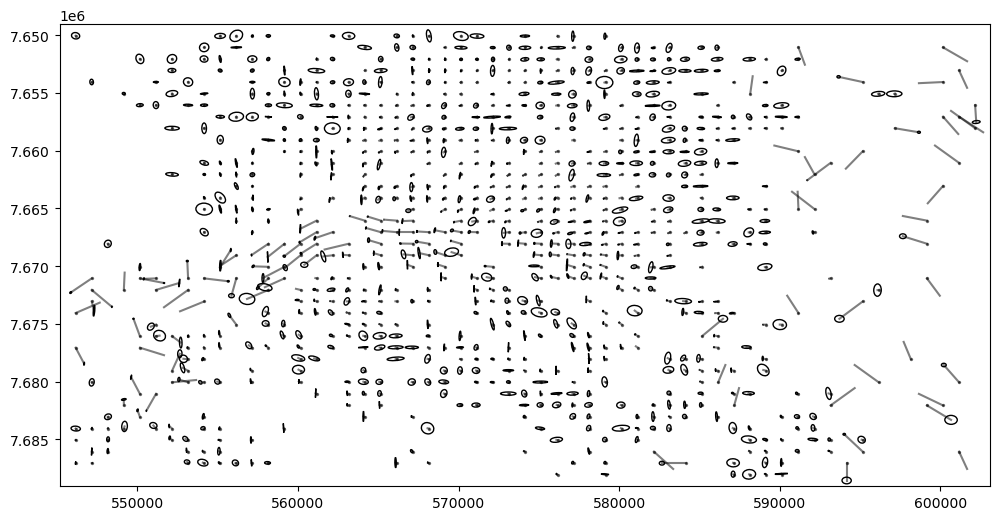

In [16]:
match_mask = np.logical_or(np.any(np.abs(match_score)>60, axis=2), match_X==0)
a = np.ones_like(dX)
plt.rcParams['figure.figsize'] = [12.,6.]
fig, ax = plt.subplots()
plot_displacement_vectors(sample_X, sample_Y, -dX, -dY, match_score[...,1],match_score[...,2],match_score[...,3],
                              scaling=(5, .3), sampling=10, dots=True, M=match_mask, ax=ax)
ax.set(xlim=(sample_X[0][0], sample_X[-1][-1]), ylim=(sample_Y[0][0], sample_Y[-1][-1]));

In [ ]:
sample_X[0][0]

In [ ]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
ax.add_patch(Ellipse((1,.8),width=1,height=2, angle=45, facecolor='none', edgecolor='red'))
ax.set(xlim=(-1, +3), ylim=(-1, +3));

In [ ]:
sampling = 10
a,b = np.zeros_like(sample_X), np.zeros_like(sample_X)
a[::sampling,...], b[...,::sampling] = 1, 1
sparse_grd = np.logical_and(a,b)

idxs = np.where(np.logical_and(~match_mask, sparse_grd))
idxs[0][123]
#plt.scatter(sample_X[idxs],sample_Y[idxs],s=2,c='k', alpha=.5)
#plt.imshow(np.logical_and(np.mod(grds[0],sampling)==0, np.mod(grds[1],sampling)==0))
#plt.imshow(np.logical_and(~match_mask, sparse_grd))
#plt.imshow(IN)

the dispersion estimates can be converted to a single-valued geometric precision describtor. Such as the point error, or the geometric mean.

### other precision describtors
Other describtors do exist as well, for sake of completeness, some are calculated now as well.

In [ ]:
from dhdt.processing.coupling_tools import match_pair